In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [18]:
blackout_choices = np.array([
    [3*3600, 4*3600],
    [6*3600, 4*3600],
    [14*3600, 4*3600],
    [19*3600, 4*3600],
])

fc = 2.6 #2.6 GHz
bandwidth = 1e7 #10 MHz
temp = 40 + 273.15 # 40 celsius in kelvin
boltz = 1.381e-23
epsilon = 1e-7
row_bs = 5
col_bs = 5
grid_width = 2000 + 1000*row_bs
grid_height = 2000 + 1000*col_bs
bs_loc = np.mgrid[1000:grid_width-1000:1000, 1000:grid_height-1000:1000]
bs_loc = bs_loc.reshape((2,-1)).T
bs_loc += 100 - np.random.randint(0, 200, bs_loc.shape)

bs_power = np.array([40. for i in bs_loc])

bs_blackout = blackout_choices[np.random.randint(0,3, (row_bs*col_bs))]

class Environment():
    def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height, n_nearest):
        self.bs_loc = bs_loc
        self.bs_power = bs_power
        self.electricity = np.zeros_like(bs_power)
        self.bs_blackout_start = bs_blackouts[:,0]
        self.bs_blackout_end = np.sum(bs_blackouts, axis=-1)
        self.apply_blackouts(0)
        self.max_power = max_power # in watt
        self.min_power = min_power
        self.n_actions = n_actions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.points = np.mgrid[0:grid_width, 0:grid_height]
        self.points = np.stack(self.points, axis=-1)
        self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
        self.bit_rate = self.bit_rate_from_grid()
        self.reward = self.get_reward()
        self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
        self.n_nearest = min(n_nearest, bs_power.shape[0])
        self.n_bs = bs_power.shape[0]
        
        
    
    def get_input_dim(self):
        return self.n_nearest*4 # after adding has electricity attrib 3 will be changed to 4
    
    def get_output_dim(self):
        return self.n_actions
    
    def apply_blackouts(self, time):
        self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)
    
    def make_action(self, bs_index, action):
        state = self.get_state(bs_index) 
        self.bs_power[bs_index] = self.actions[action]
        self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
        self.bit_rate = self.bit_rate_from_grid()
        next_state = self.get_state(bs_index)
        reward = self.get_reward()
        return state, action, next_state, reward
        
    def watt_to_dbm(self, watt):
        return 10*np.log10(1000*watt)

    def dbm_to_watt(self, dbm):
        return np.power(10, dbm/10)/1000

    def path_loss(self, distance, frequency=fc):
    #     return 36.7*np.log10(distance) + 47.7 + 26*np.log10(frequency)
        return 35*np.log10(distance) + 35.7

    def power_grid(self, bs_loc, bs_power, points):
        powers = []
        for loc, power in zip(bs_loc, bs_power):
            distance = np.linalg.norm(loc - points+epsilon, axis=-1)
            powers.append(power - self.path_loss(distance))
        return np.stack(powers, axis=-1)

    def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
        return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
    def bit_rate_from_grid(self):
        max_power = self.dbm_to_watt(self.powers.max(axis=-1))
        interference_power = self.dbm_to_watt(self.powers).sum(axis=-1) - max_power
        return self.get_bit_rate_sinr(max_power, interference_power)

    def bit_rate_cost_function(self, b_rate):
        total_points = 1
        for i in b_rate.shape:
            total_points *= i

        under_1mb = b_rate<(1024**2)*8
        under_1mb = under_1mb.sum()
        min_speed = b_rate.min()/(1024*1024*8) #1MB
        return 10*under_1mb/total_points + 1/(min_speed+epsilon)

    def get_reward(self):
        return 10 - self.bit_rate_cost_function(self.bit_rate) - np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
    
    def get_state(self, bs_index):
        x,y = self.bs_loc[bs_index]
        powers = self.powers[np.round(x),np.round(y),:].reshape(-1)
        indecies = np.argsort(powers)[::-1][:self.n_nearest]
        bs_index_posistion = np.where(indecies == bs_index)[0]
        
        if bs_index_posistion.size > 0:
            indecies = np.delete(indecies, bs_index_posistion)
            indecies = indecies[:self.n_nearest]
        else:
            indecies = indecies[:self.n_nearest-1]
            
        bs_power = powers[bs_index]
        state = np.array([powers[bs_index], self.electricity[bs_index], 0, 0])
        nearest_powers = powers[np.array(indecies)]
        nearest_elec = self.electricity[np.array(indecies)]
        diff =  self.bs_loc[np.array(indecies)] - self.bs_loc[bs_index]
        nearest_distances = np.linalg.norm(diff, axis=-1)
        nearest_angles = np.arctan2(diff[:,1].reshape(-1), diff[:,0].reshape(-1))
        
        return np.hstack((state, np.stack([nearest_powers, nearest_elec,
                                           nearest_distances, nearest_angles], axis=-1).reshape(-1)))
    
    def plot_bit_rate(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_bit_rate(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_power_grid(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_power_grid(self):
        plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)

[[50400 14400]
 [10800 14400]
 [21600 14400]
 [50400 14400]
 [21600 14400]
 [50400 14400]
 [50400 14400]
 [50400 14400]
 [21600 14400]
 [21600 14400]
 [21600 14400]
 [10800 14400]
 [50400 14400]
 [21600 14400]
 [10800 14400]
 [50400 14400]
 [21600 14400]
 [10800 14400]
 [21600 14400]
 [21600 14400]
 [10800 14400]
 [21600 14400]
 [50400 14400]
 [10800 14400]
 [50400 14400]]


In [3]:
class DQN(nn.Module): # ready
    def __init__(self, n_inputs, n_actions):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(in_features=n_inputs, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=n_actions)

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [4]:
Experience = namedtuple(
    "Experience", ("state", "action", "next_state", "reward")) # ready

In [5]:
class ReplayMemory(): # ready
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [6]:
class EpsilonGreedyStrategy(): # ready
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * np.exp(-1. * current_step * self.decay)

In [7]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action])
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1)

In [8]:
class QValues():
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        values = target_net(next_states).max(dim=1)[0].detach()
        return values

In [9]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)

    moving_avg = get_moving_avg(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period,
          "episode moving avg:", moving_avg[-1])
#     if is_ipython:
#         display.clear_output(wait=True)

In [10]:
def get_moving_avg(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(
            dim=1).flatten(start_dim=0)
    else:
        moving_avg = torch.zeros_like(values)
    return moving_avg.numpy()

In [11]:
def extract_tensors(exps):
    batch = Experience(*zip(*exps))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.next_state)
    t4 = torch.cat(batch.reward)

    return (t1, t2, t3, t4)

In [21]:
batch_size = 256
gamma = 0.7
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 1000
lr = 0.001
num_episodes = 5000

env = Environment(bs_loc, bs_power, bs_blackout,10, 0, 11, grid_width, grid_height, 4)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, env.get_output_dim())
memory = ReplayMemory(memory_size)

policy_net = DQN(env.get_input_dim(), env.get_output_dim())
target_net = DQN(env.get_input_dim(), env.get_output_dim())
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

<ipython-input-20-ffc16bea6665>:53: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*watt)


In [22]:
rewards_history = []
for episode in range(num_episodes):
    timer = time.time()
    print("\n\nEPISODE:", episode+1)
    
    env.apply_blackouts(episode+1)
    
    for i in range(env.n_bs):
        state = torch.tensor(env.get_state(i), dtype=torch.float).unsqueeze(0)

        action = agent.select_action(state, policy_net)
        _, action, next_state, reward = env.make_action(i, action)
        
        rewards_history.append(reward)

        reward = torch.tensor([reward], dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            exps = memory.sample(batch_size)
            states, actions, next_states, rewards = extract_tensors(exps)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            optimizer.zero_grad()
            loss = F.smooth_l1_loss(
                current_q_values, target_q_values.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print("EPISODE DONE IN {} SECONDS, reward {}, action {}".format(time.time() - timer, reward[0], action[0]))



EPISODE: 1
EPISODE DONE IN 2.23905348777771 SECONDS, reward -6.396927833557129, action 1
EPISODE DONE IN 4.365621089935303 SECONDS, reward -5.2661213874816895, action 0
EPISODE DONE IN 6.494985342025757 SECONDS, reward -4.774501800537109, action 4
EPISODE DONE IN 8.61030101776123 SECONDS, reward -4.890564918518066, action 6


EPISODE: 2
EPISODE DONE IN 2.619133710861206 SECONDS, reward -3.396500587463379, action 0
EPISODE DONE IN 4.743169546127319 SECONDS, reward -4.494022846221924, action 6
EPISODE DONE IN 6.874470233917236 SECONDS, reward -4.494022846221924, action 4
EPISODE DONE IN 8.998049974441528 SECONDS, reward -3.2858059406280518, action 7


EPISODE: 3
EPISODE DONE IN 2.218256711959839 SECONDS, reward -8.70699405670166, action 5
EPISODE DONE IN 4.426408529281616 SECONDS, reward -8.042205810546875, action 3
EPISODE DONE IN 6.677329778671265 SECONDS, reward -7.619953155517578, action 6
EPISODE DONE IN 8.898887872695923 SECONDS, reward -8.285063743591309, action 4


EPISODE: 4
E

EPISODE DONE IN 1.9136812686920166 SECONDS, reward -21.154136657714844, action 5
EPISODE DONE IN 3.9066288471221924 SECONDS, reward -10.81537914276123, action 2
EPISODE DONE IN 6.027541399002075 SECONDS, reward -11.397014617919922, action 3
EPISODE DONE IN 8.23463773727417 SECONDS, reward -8.666144371032715, action 5


EPISODE: 27
EPISODE DONE IN 2.219909906387329 SECONDS, reward -4.735631942749023, action 1
EPISODE DONE IN 4.428640842437744 SECONDS, reward -4.828263282775879, action 3
EPISODE DONE IN 6.643805980682373 SECONDS, reward -4.974921226501465, action 4
EPISODE DONE IN 8.850557327270508 SECONDS, reward -5.203013896942139, action 8


EPISODE: 28
EPISODE DONE IN 2.216522216796875 SECONDS, reward -4.942055702209473, action 3
EPISODE DONE IN 4.426922559738159 SECONDS, reward -5.539551258087158, action 6
EPISODE DONE IN 6.645169496536255 SECONDS, reward -5.539551258087158, action 4
EPISODE DONE IN 8.765830516815186 SECONDS, reward -7.74782133102417, action 0


EPISODE: 29
EPISODE 

EPISODE DONE IN 9.181569576263428 SECONDS, reward -11.470117568969727, action 1


EPISODE: 51
EPISODE DONE IN 2.2880303859710693 SECONDS, reward -12.889762878417969, action 7
EPISODE DONE IN 4.524988412857056 SECONDS, reward -12.462027549743652, action 1
EPISODE DONE IN 6.846118211746216 SECONDS, reward -12.356355667114258, action 2
EPISODE DONE IN 9.093249797821045 SECONDS, reward -12.718636512756348, action 8


EPISODE: 52
EPISODE DONE IN 2.2452502250671387 SECONDS, reward -12.718636512756348, action 7
EPISODE DONE IN 4.451068162918091 SECONDS, reward -11.20676326751709, action 3
EPISODE DONE IN 6.660761833190918 SECONDS, reward -9.984431266784668, action 8
EPISODE DONE IN 8.861959218978882 SECONDS, reward -9.984431266784668, action 8


EPISODE: 53
EPISODE DONE IN 2.2958922386169434 SECONDS, reward -8.599343299865723, action 6
EPISODE DONE IN 4.4981606006622314 SECONDS, reward -8.964300155639648, action 6
EPISODE DONE IN 6.710667371749878 SECONDS, reward -9.641918182373047, action 5


EPISODE DONE IN 6.542005300521851 SECONDS, reward -11.01563835144043, action 0
EPISODE DONE IN 8.655756950378418 SECONDS, reward -11.15576457977295, action 6


EPISODE: 76
EPISODE DONE IN 2.113567590713501 SECONDS, reward -9.718331336975098, action 5
EPISODE DONE IN 4.134204626083374 SECONDS, reward -11.321500778198242, action 0
EPISODE DONE IN 6.17864990234375 SECONDS, reward -11.321500778198242, action 0
EPISODE DONE IN 8.27933931350708 SECONDS, reward -22.187671661376953, action 1


EPISODE: 77
EPISODE DONE IN 2.0618443489074707 SECONDS, reward -35.183109283447266, action 1
EPISODE DONE IN 4.283813953399658 SECONDS, reward -17.68265724182129, action 2
EPISODE DONE IN 6.6113550662994385 SECONDS, reward -5.299343585968018, action 2
EPISODE DONE IN 8.864080905914307 SECONDS, reward -4.478099346160889, action 4


EPISODE: 78
EPISODE DONE IN 2.1659154891967773 SECONDS, reward -7.153262138366699, action 0
EPISODE DONE IN 4.426259994506836 SECONDS, reward -7.836299896240234, action 6
EPISO

EPISODE DONE IN 4.005749702453613 SECONDS, reward -17.804615020751953, action 0
EPISODE DONE IN 6.033859968185425 SECONDS, reward -19.834184646606445, action 3
EPISODE DONE IN 8.052744388580322 SECONDS, reward -19.834184646606445, action 0


EPISODE: 101
EPISODE DONE IN 2.031019687652588 SECONDS, reward -29.764801025390625, action 1
EPISODE DONE IN 4.069420099258423 SECONDS, reward -29.764801025390625, action 0
EPISODE DONE IN 5.983039140701294 SECONDS, reward -86.46080780029297, action 0
EPISODE DONE IN 7.88378381729126 SECONDS, reward -86.46080780029297, action 0


EPISODE: 102
EPISODE DONE IN 1.9044981002807617 SECONDS, reward -21.154136657714844, action 5
EPISODE DONE IN 3.810676097869873 SECONDS, reward -21.154136657714844, action 0
EPISODE DONE IN 5.717270374298096 SECONDS, reward -21.154136657714844, action 0
EPISODE DONE IN 7.730165004730225 SECONDS, reward -13.28564453125, action 4


EPISODE: 103
EPISODE DONE IN 2.0176239013671875 SECONDS, reward -15.955238342285156, action 7


EPISODE DONE IN 2.0169456005096436 SECONDS, reward -36.82756805419922, action 2
EPISODE DONE IN 4.126631498336792 SECONDS, reward -18.909191131591797, action 1
EPISODE DONE IN 6.120004177093506 SECONDS, reward -18.728635787963867, action 0
EPISODE DONE IN 8.228705644607544 SECONDS, reward -14.267126083374023, action 7


EPISODE: 126
EPISODE DONE IN 2.0311968326568604 SECONDS, reward -10.49156665802002, action 0
EPISODE DONE IN 3.9268765449523926 SECONDS, reward -9.546906471252441, action 0
EPISODE DONE IN 5.927217721939087 SECONDS, reward -2.6712796688079834, action 1
EPISODE DONE IN 7.921852350234985 SECONDS, reward -9.861931800842285, action 3


EPISODE: 127
EPISODE DONE IN 1.9969685077667236 SECONDS, reward -9.861931800842285, action 0
EPISODE DONE IN 4.003129243850708 SECONDS, reward -9.861931800842285, action 0
EPISODE DONE IN 6.002640008926392 SECONDS, reward -1.524810791015625, action 8
EPISODE DONE IN 7.993456840515137 SECONDS, reward -1.7058779001235962, action 2


EPISODE: 12

EPISODE DONE IN 7.9684977531433105 SECONDS, reward -21.154136657714844, action 0


EPISODE: 150
EPISODE DONE IN 1.658006191253662 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.3321926593780518 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.001868009567261 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.902730226516724 SECONDS, reward -11.80997371673584, action 6


EPISODE: 151
EPISODE DONE IN 1.9086871147155762 SECONDS, reward -11.80997371673584, action 0
EPISODE DONE IN 3.9383838176727295 SECONDS, reward -10.469008445739746, action 3
EPISODE DONE IN 5.978132724761963 SECONDS, reward -10.469008445739746, action 0
EPISODE DONE IN 8.009796857833862 SECONDS, reward -10.167935371398926, action 3


EPISODE: 152
EPISODE DONE IN 2.125250816345215 SECONDS, reward -13.368659019470215, action 2
EPISODE DONE IN 4.151149272918701 SECONDS, reward -18.905628204345703, action 0
EPISODE DONE IN 6.275512218475342 SECONDS, reward -13.564762115478516, action 3
EPISODE DONE IN 8

EPISODE DONE IN 8.5336012840271 SECONDS, reward -10.850295066833496, action 8


EPISODE: 175
EPISODE DONE IN 2.205390214920044 SECONDS, reward -2.4581007957458496, action 0
EPISODE DONE IN 4.212168216705322 SECONDS, reward -1.524810791015625, action 0
EPISODE DONE IN 6.178580045700073 SECONDS, reward -7.8201141357421875, action 0
EPISODE DONE IN 8.012309551239014 SECONDS, reward -10000000.0, action 0


EPISODE: 176
EPISODE DONE IN 1.7772719860076904 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.93923282623291 SECONDS, reward -11.829377174377441, action 6
EPISODE DONE IN 6.064680099487305 SECONDS, reward -7.137362957000732, action 4
EPISODE DONE IN 8.186563968658447 SECONDS, reward -7.515113353729248, action 1


EPISODE: 177
EPISODE DONE IN 2.126047372817993 SECONDS, reward -7.515113353729248, action 0
EPISODE DONE IN 4.127925634384155 SECONDS, reward -6.522812843322754, action 0
EPISODE DONE IN 6.063499927520752 SECONDS, reward -85.31786346435547, action 0
EPISODE DONE IN 7.7

EPISODE DONE IN 5.99777889251709 SECONDS, reward -10.750896453857422, action 0
EPISODE DONE IN 7.984438896179199 SECONDS, reward -10.750896453857422, action 0


EPISODE: 200
EPISODE DONE IN 1.9007959365844727 SECONDS, reward -27.141239166259766, action 0
EPISODE DONE IN 3.5660042762756348 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.31192421913147 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.110466718673706 SECONDS, reward -10000000.0, action 0


EPISODE: 201
EPISODE DONE IN 1.7368903160095215 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.4700205326080322 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.15343976020813 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.050442457199097 SECONDS, reward -14.926665306091309, action 5


EPISODE: 202
EPISODE DONE IN 1.9039251804351807 SECONDS, reward -14.926665306091309, action 0
EPISODE DONE IN 3.807199239730835 SECONDS, reward -14.926665306091309, action 0
EPISODE DONE IN 5.785823345184326 SECONDS

EPISODE DONE IN 5.56714129447937 SECONDS, reward -7.062016487121582, action 4
EPISODE DONE IN 7.6875975131988525 SECONDS, reward -4.35484504699707, action 6


EPISODE: 225
EPISODE DONE IN 2.1317503452301025 SECONDS, reward -4.35484504699707, action 0
EPISODE DONE IN 4.2487568855285645 SECONDS, reward -4.35484504699707, action 5
EPISODE DONE IN 6.271807909011841 SECONDS, reward -5.080244541168213, action 0
EPISODE DONE IN 8.166605949401855 SECONDS, reward -14.94920539855957, action 0


EPISODE: 226
EPISODE DONE IN 1.8968772888183594 SECONDS, reward -14.94920539855957, action 0
EPISODE DONE IN 3.5467305183410645 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.456000804901123 SECONDS, reward -14.926665306091309, action 5
EPISODE DONE IN 7.347124814987183 SECONDS, reward -14.926665306091309, action 0


EPISODE: 227
EPISODE DONE IN 1.8940863609313965 SECONDS, reward -14.926665306091309, action 0
EPISODE DONE IN 3.9116575717926025 SECONDS, reward -7.0545878410339355, action 4
EPISODE

EPISODE DONE IN 6.317119359970093 SECONDS, reward -10.646151542663574, action 0
EPISODE DONE IN 8.55425214767456 SECONDS, reward -11.148813247680664, action 6


EPISODE: 250
EPISODE DONE IN 2.135120391845703 SECONDS, reward -5.080244541168213, action 0
EPISODE DONE IN 4.233476161956787 SECONDS, reward -11.80997371673584, action 0
EPISODE DONE IN 6.342333555221558 SECONDS, reward -3.2654097080230713, action 3
EPISODE DONE IN 8.328333139419556 SECONDS, reward -27.10552215576172, action 0


EPISODE: 251
EPISODE DONE IN 2.116257905960083 SECONDS, reward -16.56825065612793, action 5
EPISODE DONE IN 4.387597560882568 SECONDS, reward -11.449684143066406, action 1
EPISODE DONE IN 6.54637336730957 SECONDS, reward -10.696940422058105, action 0
EPISODE DONE IN 8.640864133834839 SECONDS, reward -10.696940422058105, action 0


EPISODE: 252
EPISODE DONE IN 2.015169382095337 SECONDS, reward -85.42497253417969, action 0
EPISODE DONE IN 3.767975330352783 SECONDS, reward -10000000.0, action 0
EPISODE DO

EPISODE DONE IN 1.6641488075256348 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.3189215660095215 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.218951463699341 SECONDS, reward -19.538095474243164, action 4
EPISODE DONE IN 7.115889072418213 SECONDS, reward -19.538095474243164, action 0


EPISODE: 276
EPISODE DONE IN 1.8990733623504639 SECONDS, reward -19.538095474243164, action 0
EPISODE DONE IN 3.7935101985931396 SECONDS, reward -19.538095474243164, action 0
EPISODE DONE IN 5.452894926071167 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.107717037200928 SECONDS, reward -10000000.0, action 0


EPISODE: 277
EPISODE DONE IN 1.663886308670044 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.56138277053833 SECONDS, reward -41.929996490478516, action 2
EPISODE DONE IN 5.587130069732666 SECONDS, reward -16.280006408691406, action 2
EPISODE DONE IN 7.708628177642822 SECONDS, reward -4.996547698974609, action 5


EPISODE: 278
EPISODE DONE IN 2.208744764328003

EPISODE DONE IN 4.0173375606536865 SECONDS, reward -4.581667423248291, action 0
EPISODE DONE IN 6.020898818969727 SECONDS, reward -3.5406901836395264, action 6
EPISODE DONE IN 7.922400236129761 SECONDS, reward -11.80997371673584, action 0


EPISODE: 301
EPISODE DONE IN 1.9672858715057373 SECONDS, reward -11.80997371673584, action 0
EPISODE DONE IN 4.089681386947632 SECONDS, reward -4.0137481689453125, action 6
EPISODE DONE IN 6.006315231323242 SECONDS, reward -11.829377174377441, action 0
EPISODE DONE IN 7.979003190994263 SECONDS, reward -11.829377174377441, action 0


EPISODE: 302
EPISODE DONE IN 1.9875061511993408 SECONDS, reward -11.829377174377441, action 0
EPISODE DONE IN 3.6633386611938477 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.328430414199829 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.229116439819336 SECONDS, reward -85.31786346435547, action 1


EPISODE: 303
EPISODE DONE IN 1.9119513034820557 SECONDS, reward -85.31786346435547, action 0
EPISODE DON

EPISODE DONE IN 4.143451452255249 SECONDS, reward -11.591934204101562, action 0
EPISODE DONE IN 6.167480230331421 SECONDS, reward -11.591934204101562, action 0
EPISODE DONE IN 8.069846630096436 SECONDS, reward -18.279748916625977, action 0


EPISODE: 326
EPISODE DONE IN 1.6624467372894287 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.387907028198242 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.050633668899536 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.808851957321167 SECONDS, reward -10000000.0, action 0


EPISODE: 327
EPISODE DONE IN 1.799426794052124 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.5571093559265137 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.363576650619507 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.138782024383545 SECONDS, reward -10000000.0, action 0


EPISODE: 328
EPISODE DONE IN 1.8390049934387207 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.8518335819244385 SECONDS, reward -10000000.0, 

EPISODE DONE IN 5.211595296859741 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.10297966003418 SECONDS, reward -41.876434326171875, action 2


EPISODE: 351
EPISODE DONE IN 1.8996989727020264 SECONDS, reward -41.876434326171875, action 0
EPISODE DONE IN 3.8074193000793457 SECONDS, reward -41.876434326171875, action 0
EPISODE DONE IN 5.808168649673462 SECONDS, reward -10.170105934143066, action 3
EPISODE DONE IN 7.702329635620117 SECONDS, reward -27.10552215576172, action 0


EPISODE: 352
EPISODE DONE IN 1.9027774333953857 SECONDS, reward -27.10552215576172, action 0
EPISODE DONE IN 3.865398406982422 SECONDS, reward -27.10552215576172, action 0
EPISODE DONE IN 5.536283016204834 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.1896398067474365 SECONDS, reward -10000000.0, action 0


EPISODE: 353
EPISODE DONE IN 1.9063529968261719 SECONDS, reward -24.511316299438477, action 4
EPISODE DONE IN 3.8909053802490234 SECONDS, reward -9.923580169677734, action 5
EPISODE DONE IN 5.

EPISODE DONE IN 1.9055166244506836 SECONDS, reward -7.835620880126953, action 0
EPISODE DONE IN 3.557739734649658 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.216783046722412 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.870137691497803 SECONDS, reward -10000000.0, action 0


EPISODE: 377
EPISODE DONE IN 1.6580309867858887 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.3094358444213867 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 4.9680235385894775 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.637718200683594 SECONDS, reward -10000000.0, action 0


EPISODE: 378
EPISODE DONE IN 1.7119777202606201 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.6029863357543945 SECONDS, reward -85.42497253417969, action 1
EPISODE DONE IN 5.588895082473755 SECONDS, reward -85.42497253417969, action 0
EPISODE DONE IN 7.710672616958618 SECONDS, reward -34.00605392456055, action 1


EPISODE: 379
EPISODE DONE IN 2.1207447052001953 SECONDS, reward -36.41

EPISODE DONE IN 5.307826995849609 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.959076881408691 SECONDS, reward -10000000.0, action 0


EPISODE: 402
EPISODE DONE IN 1.657651662826538 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.3115363121032715 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 4.970449924468994 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.8616416454315186 SECONDS, reward -85.31786346435547, action 1


EPISODE: 403
EPISODE DONE IN 1.907646894454956 SECONDS, reward -85.31786346435547, action 0
EPISODE DONE IN 3.804194927215576 SECONDS, reward -85.31786346435547, action 0
EPISODE DONE IN 5.708242893218994 SECONDS, reward -85.31786346435547, action 0
EPISODE DONE IN 7.359317302703857 SECONDS, reward -10000000.0, action 0


EPISODE: 404
EPISODE DONE IN 1.6582989692687988 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.3105366230010986 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.009962320327759 SECONDS, reward -10000000

EPISODE DONE IN 3.9290578365325928 SECONDS, reward -7.8201141357421875, action 0
EPISODE DONE IN 5.911873817443848 SECONDS, reward -7.8201141357421875, action 0
EPISODE DONE IN 7.854816913604736 SECONDS, reward -9.546906471252441, action 7


EPISODE: 428
EPISODE DONE IN 1.9522137641906738 SECONDS, reward -9.546906471252441, action 0
EPISODE DONE IN 3.9207189083099365 SECONDS, reward -9.546906471252441, action 0
EPISODE DONE IN 5.830113649368286 SECONDS, reward -9.546906471252441, action 0
EPISODE DONE IN 7.492462158203125 SECONDS, reward -10000000.0, action 0


EPISODE: 429
EPISODE DONE IN 1.7059080600738525 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.4310762882232666 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.169665813446045 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.839435338973999 SECONDS, reward -10000000.0, action 0


EPISODE: 430
EPISODE DONE IN 1.6937689781188965 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.4018983840942383 SECOND

EPISODE DONE IN 1.773982048034668 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.5530669689178467 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.335551023483276 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 7.083042621612549 SECONDS, reward -10000000.0, action 0


EPISODE: 454
EPISODE DONE IN 1.7461636066436768 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.439790964126587 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.190114498138428 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.884045600891113 SECONDS, reward -10000000.0, action 0


EPISODE: 455
EPISODE DONE IN 1.7400834560394287 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.613433361053467 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.8380537033081055 SECONDS, reward -27.10552215576172, action 3
EPISODE DONE IN 7.883000612258911 SECONDS, reward -27.10552215576172, action 0


EPISODE: 456
EPISODE DONE IN 2.0599329471588135 SECONDS, reward -27.10552215576172, ac

EPISODE DONE IN 6.683754920959473 SECONDS, reward -10000000.0, action 0


EPISODE: 479
EPISODE DONE IN 1.971386432647705 SECONDS, reward -24.511316299438477, action 4
EPISODE DONE IN 4.019328832626343 SECONDS, reward -11.93644905090332, action 3
EPISODE DONE IN 6.07184100151062 SECONDS, reward -11.93644905090332, action 0
EPISODE DONE IN 8.118961334228516 SECONDS, reward -11.93644905090332, action 0


EPISODE: 480
EPISODE DONE IN 1.9011330604553223 SECONDS, reward -27.141239166259766, action 0
EPISODE DONE IN 3.5887959003448486 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 5.260886192321777 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 6.916118144989014 SECONDS, reward -10000000.0, action 0


EPISODE: 481
EPISODE DONE IN 1.655099868774414 SECONDS, reward -10000000.0, action 0
EPISODE DONE IN 3.544405937194824 SECONDS, reward -14.94920539855957, action 5
EPISODE DONE IN 5.447286605834961 SECONDS, reward -14.94920539855957, action 0
EPISODE DONE IN 7.344816446304321 SECON

KeyboardInterrupt: 

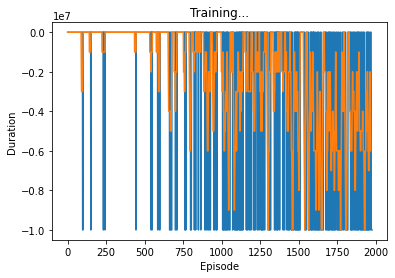

Episode 1975 
 10 episode moving avg: -6000005.5


In [23]:
plot(rewards_history, 10)

In [24]:
env.get_reward()

-10000000.0

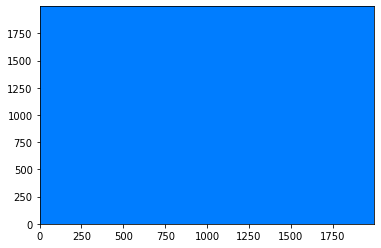

In [25]:
plt.contourf(env.points[:,:,0], env.points[:,:,1], env.bit_rate, 100, cmap = plt.cm.jet)

In [26]:
print(env.bs_power)

[-inf -inf -inf -inf]


In [6]:
np.linspace(1000, 5000, 5)

array([1000., 2000., 3000., 4000., 5000.])